<a href="https://colab.research.google.com/github/HosseinZaredar/Automatic-Internet-Login-Linux/blob/master/Uncertainty_in_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfpl = tfp.layers

***
## 1. Weight Uncertainty Using Bayesian Deep Learning (Epistemic + Aleatoric)

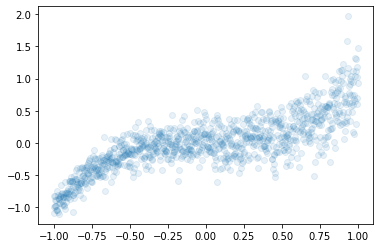

In [ ]:
# Generating the Dataset

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)

In [ ]:
# Defining Prior Function

def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [ ]:
# Defining Posterior Function

def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [ ]:
# Defining the Model

model = Sequential([
    tfpl.DenseVariational(
        units=8,
        input_shape=(1,),
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0],
        activation='sigmoid'),
    tfpl.DenseVariational(
        units=tfpl.IndependentNormal.params_size(1),
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def negative_log_likelyhood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=negative_log_likelyhood, optimizer=tf.optimizers.Adam(learning_rate=0.1))

In [ ]:
# Training the Model

model.fit(x_train, y_train, epochs=200, verbose=False)

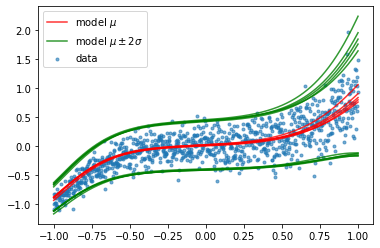

In [ ]:
# Plotting

plt.scatter(x_train, y_train, marker='.', alpha=0.6, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

***
## 2. Ensemble (Epistemic)

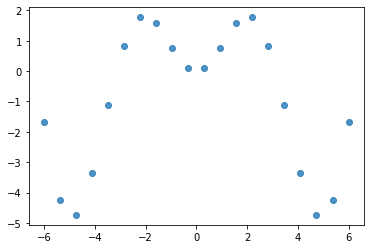

In [ ]:
# Generating the Dataset

x_train = np.linspace(0, 1, 20)
x_train = x_train * 12 - 6
y_train = x_train * np.sin(x_train)

plt.scatter(x_train, y_train, alpha=0.8)

In [ ]:
# Defining the Model

def define():
    model = Sequential([
        Dense(512, activation='relu'),
        Dropout(0.5), # only for regularization
        Dense(512, activation='relu'),
        Dropout(0.5), # only for regularization
        Dense(1, activation=None)
    ])
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(optimizer=optim, loss="mean_squared_error")
    return model

def train(x, y, model, epochs=2000):
    model.fit(x, y, batch_size=32, epochs=epochs, verbose=0)
    return model

def predict(models, x):
    mu_arr = []
    si_arr = []

    for model in models:
        y_pred = model(x)
        mu = y_pred[:, 0]
        si = y_pred[:, 1]

        mu_arr.append(mu)
        si_arr.append(si)

    mu_arr = np.array(mu_arr)
    si_arr = np.array(si_arr)
    var_arr = np.exp(si_arr)

    y_mean = np.mean(mu_arr, axis=0)
    y_variance = np.mean(var_arr + mu_arr**2, axis=0) - y_mean**2
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [ ]:
# Training the Model

models = [define() for i in range(10)]
models = [train(x_train[:, np.newaxis], y_train[:, np.newaxis], model) for model in models]

(10, 100, 1)


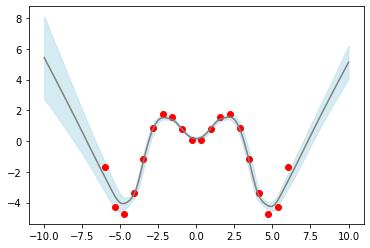

In [ ]:
# Plotting

x_test = np.linspace(0, 1, 100)
x_test = x_test * 20 - 10

samples = []
for model in models:
  samples.append(model.predict(x_test))

samples = np.array(samples)
m = np.mean(samples, axis=0).flatten()
v = np.var(samples, axis=0).flatten()

plt.plot(x_train, y_train, 'or')
plt.plot(x_test, m, 'gray')
plt.fill_between(x_test, m - 2*v**0.5, m + 2*v**0.5, 
                 color='lightblue', alpha=0.5) # plot two std (95% confidence)

***
## 3. Monte Carlo Dropout (Epistemic)

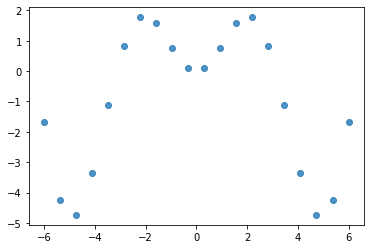

In [ ]:
# Generating the Dataset

x_train = np.linspace(0, 1, 20)
x_train = x_train * 12 - 6
y_train = x_train * np.sin(x_train)

plt.scatter(x_train, y_train, alpha=0.8)

In [ ]:
# Defining the Model

inputs = Input(shape=(1,))
x = Dense(512, activation="relu")(inputs)
x = Dropout(0.5)(x, training=True)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x, training=True)
outputs = Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss="mean_squared_error", optimizer="adam")

In [ ]:
# Training the Model

model.fit(x_train, y_train, epochs=2000, verbose=0)

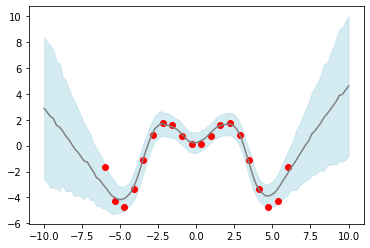

In [ ]:
# Plotting

x_test = np.linspace(0, 1, 100)
x_test = x_test * 20 - 10

samples = [model.predict(x_test) for _ in range(500)]
m = np.mean(samples, axis=0).flatten()
v = np.var(samples, axis=0).flatten()

plt.plot(x_train, y_train, 'or')
plt.plot(x_test, m, 'gray')
plt.fill_between(x_test, m - 2*v**0.5, m + 2*v**0.5, 
                 color='lightblue', alpha=0.5) # plot two std (95% confidence)

## References

- [Coursera - Probabilistic Deep Learning with TensorFlow 2](https://www.coursera.org/learn/probabilistic-deep-learning-with-tensorflow2/)
- [Why Uncertainty Matters in Deep Learning and How to Estimate It](https://everyhue.me/posts/why-uncertainty-matters/)
- [Yarin Gal - Bayesian Deep Learning](http://www.cs.ox.ac.uk/people/yarin.gal/website/bdl101/)